Loading results...
Loaded data for Model 1 (YOLOv8n)
Loaded data for Model 2 (YOLOv5nu)
Loaded data for Model 3 (YOLO11n)
Saved plot: comparison_map_50_95_vs_epoch.png


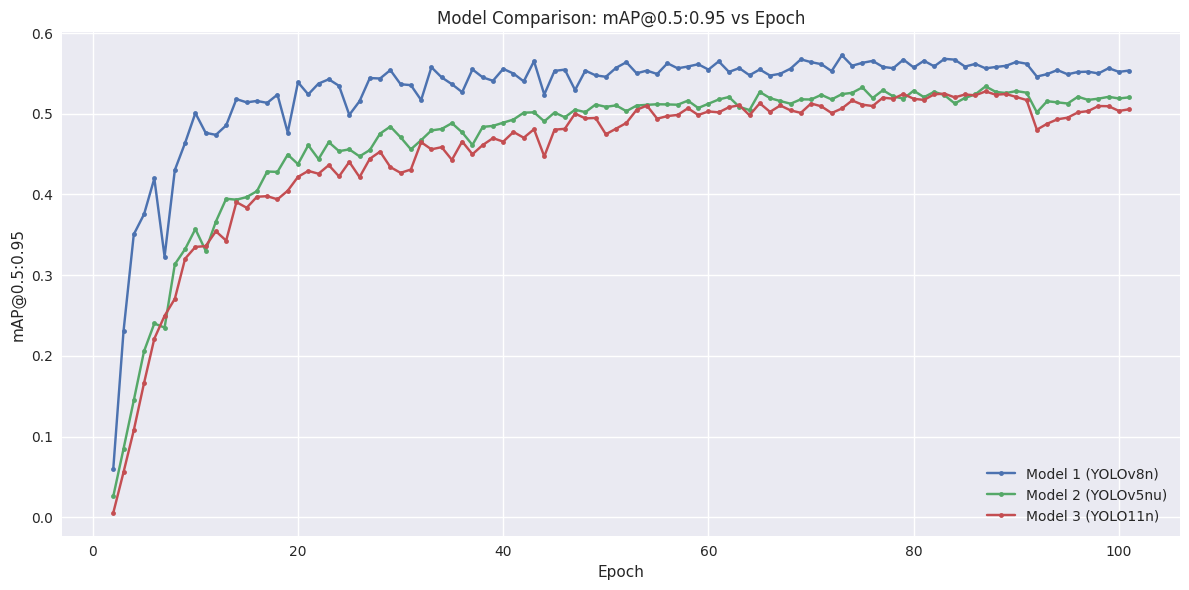

Saved plot: comparison_map_50_vs_epoch.png


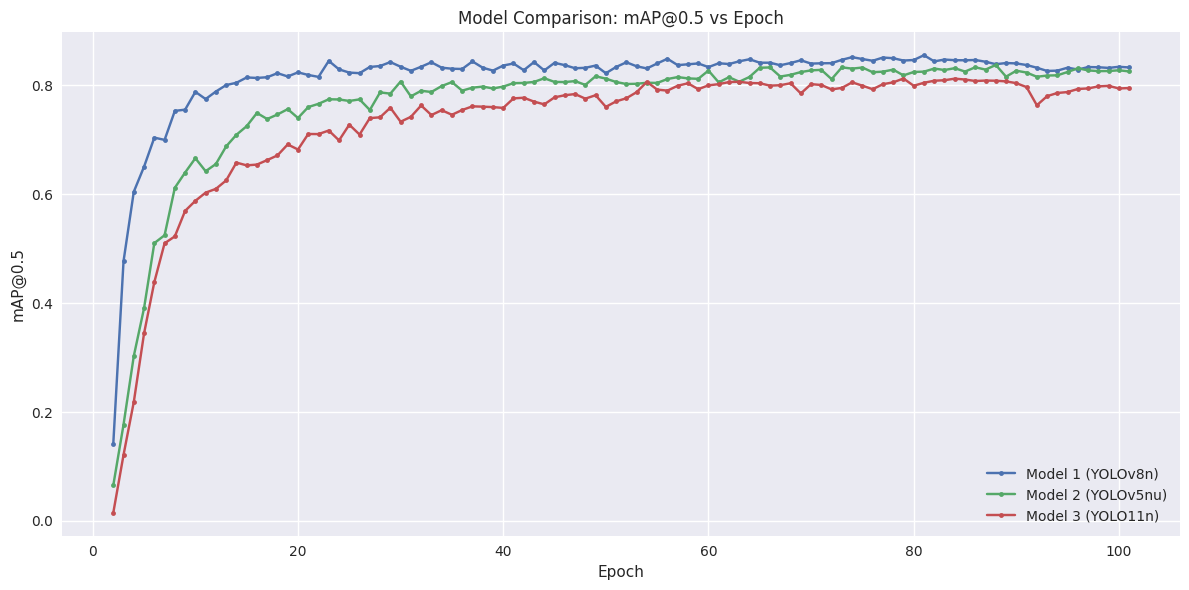

Saved plot: comparison_precision_vs_epoch.png


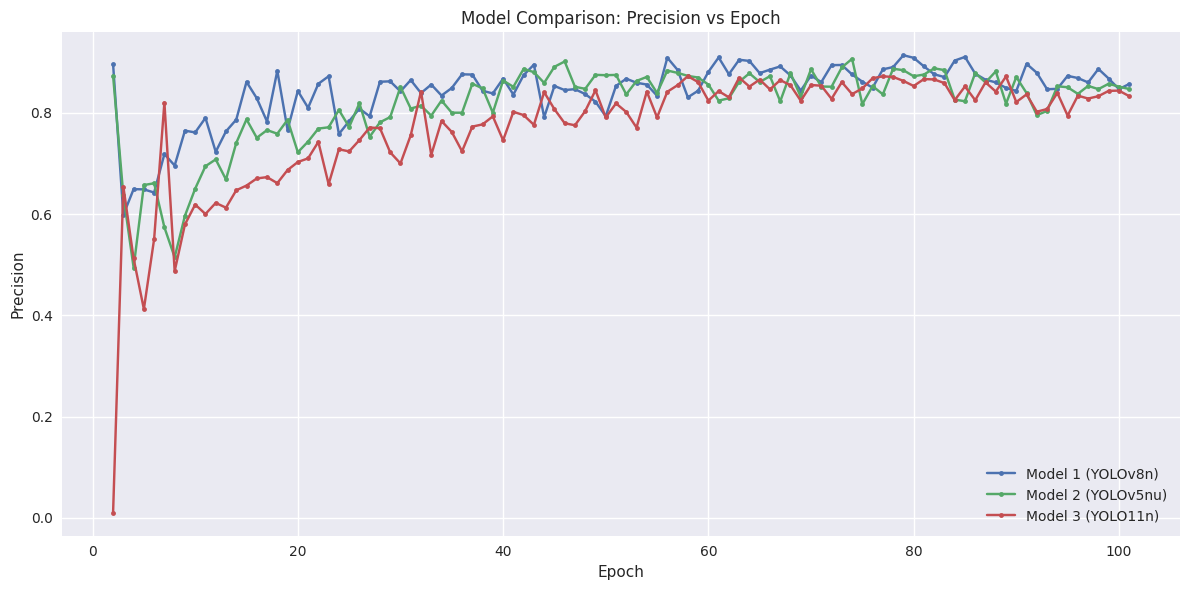

Saved plot: comparison_recall_vs_epoch.png


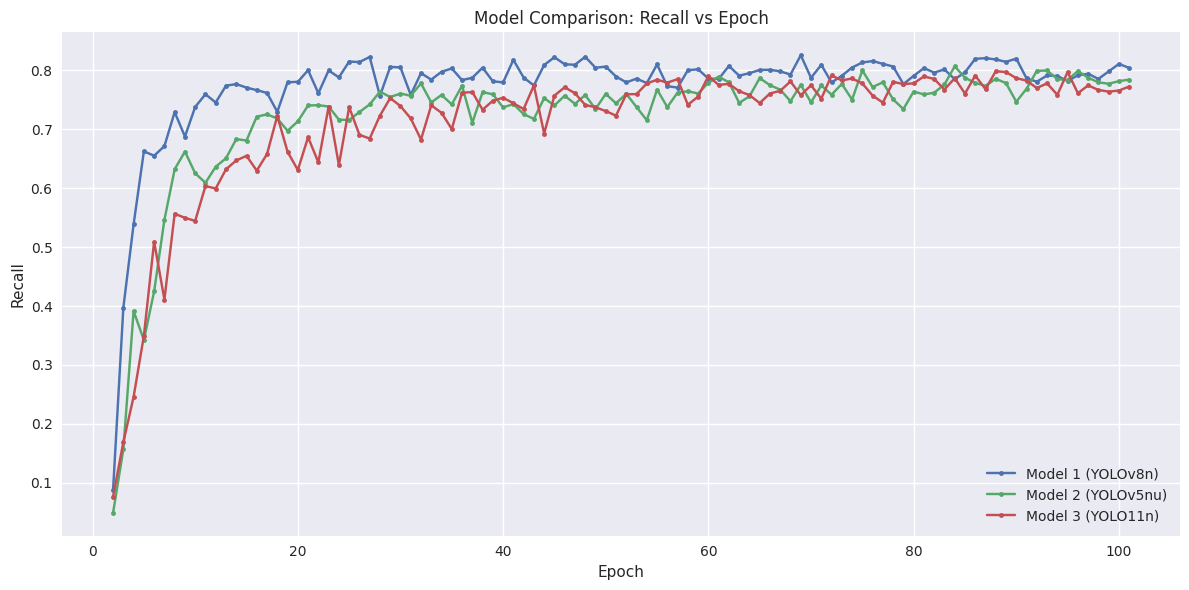

Saved plot: comparison_final_map_bar_chart.png


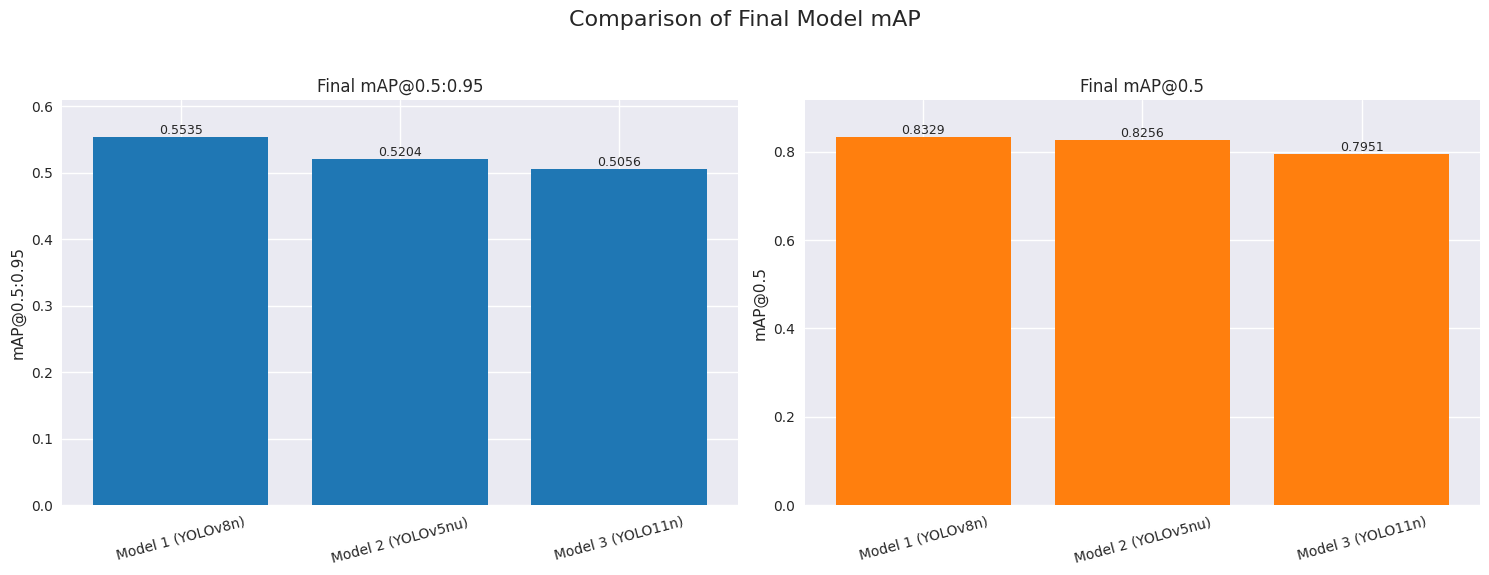

Saved plot: comparison_final_precision_recall_bar_chart.png


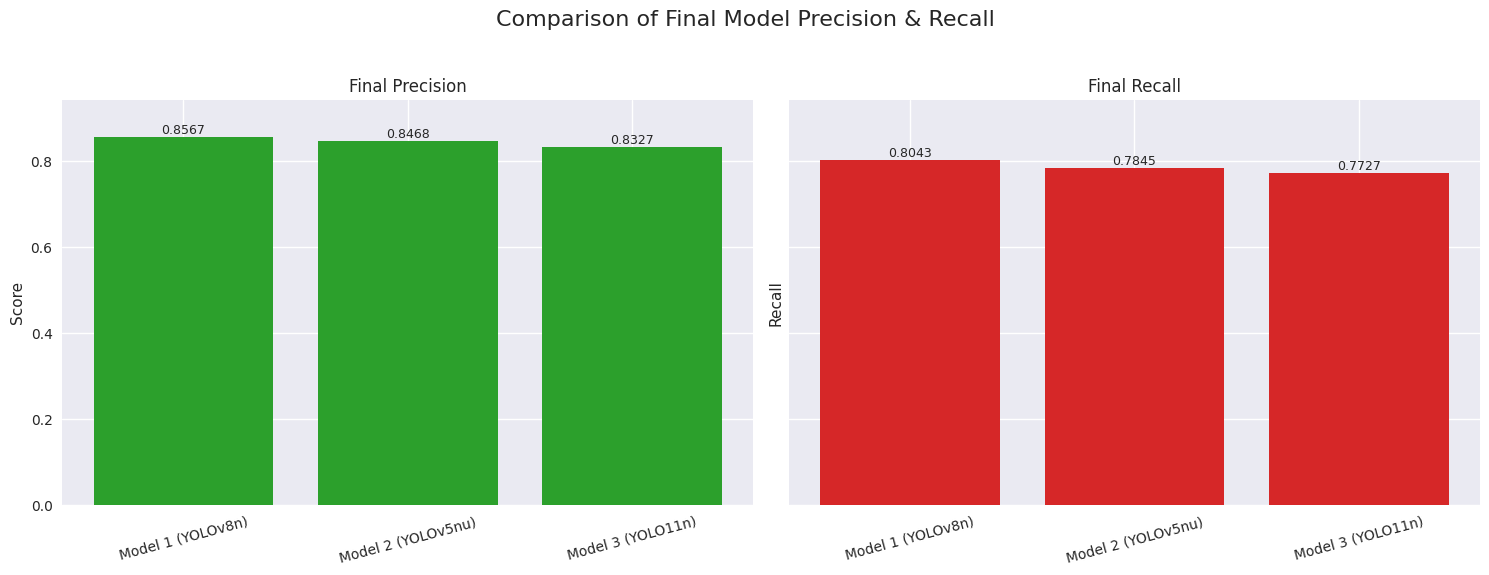

Saved plot: comparison_final_inference_speed_bar_chart.png


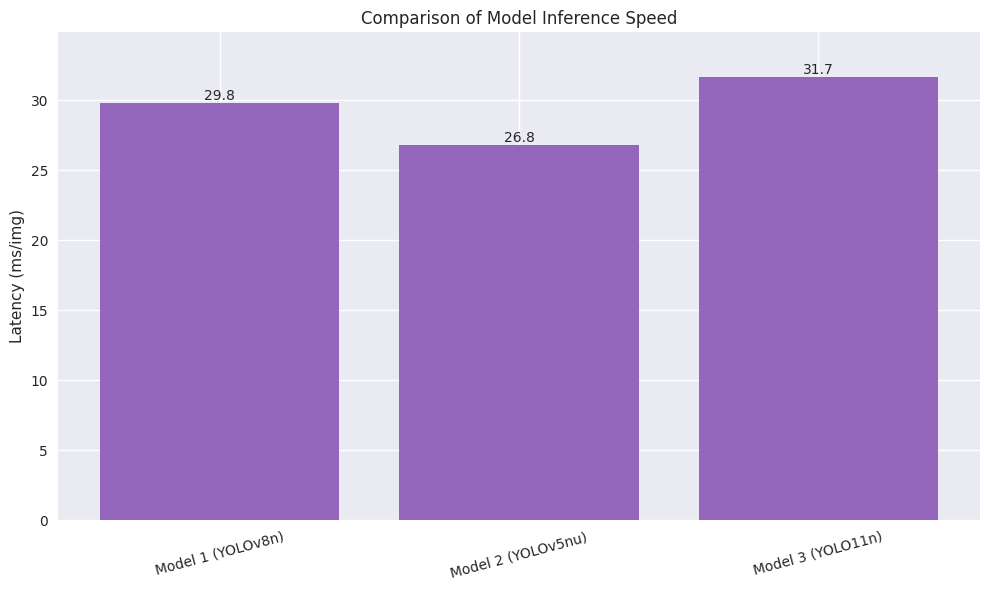

Saved plot: comparison_speed_vs_map_scatter.png


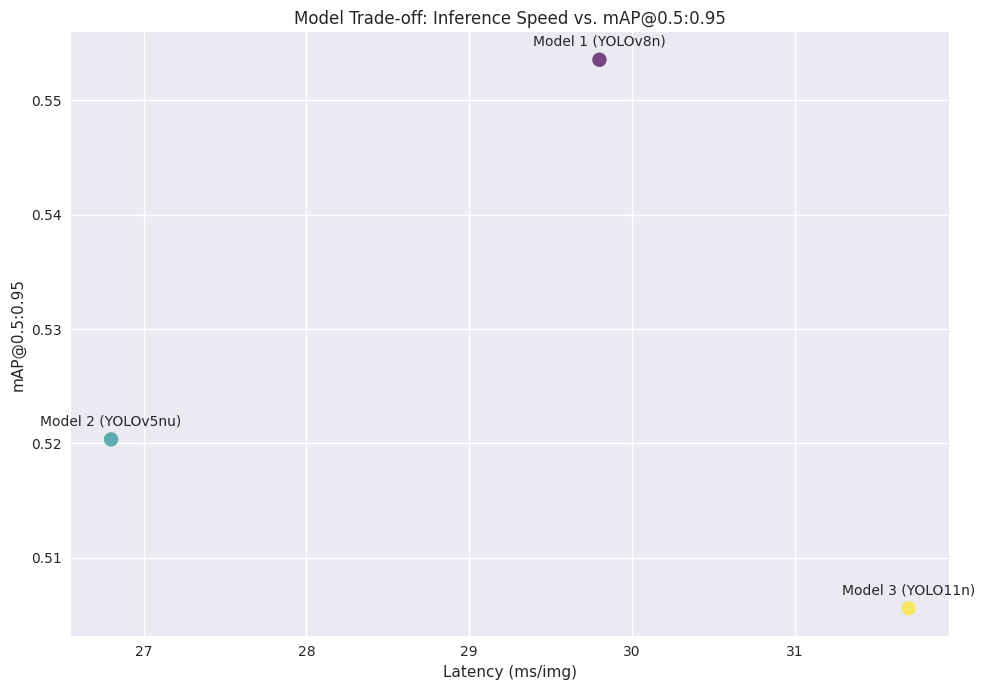


--- Final Metrics Summary ---
Model                     | Epochs | mAP@.5:.95 | mAP@.5     | Precision  | Recall     | Latency (ms/img)  
----------------------------------------------------------------------------------------------------
Model 1 (YOLOv8n)         | 100    | 0.5535     | 0.8329     | 0.8567     | 0.8043     | 29.8              
Model 2 (YOLOv5nu)        | 100    | 0.5204     | 0.8256     | 0.8468     | 0.7845     | 26.8              
Model 3 (YOLO11n)         | 100    | 0.5056     | 0.7951     | 0.8327     | 0.7727     | 31.7              


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Added for bar chart positioning
import os

# --- Configuration ---

# 1. PATHS TO YOUR RESULTS.CSV FILES
results_paths = {
    "Model 1 (YOLOv8n)": "/home/alide/Notebooks/ProyectoPC/runs/detect/train/results.csv",
    "Model 2 (YOLOv5nu)": "/home/alide/Notebooks/ProyectoPC/runs/detect/train2/results.csv",
    "Model 3 (YOLO11n)": "/home/alide/Notebooks/ProyectoPC/runs/detect/train3/results.csv",
}

# 2. MANUALLY ENTER INFERENCE SPEED (e.g., FPS or ms per image)
#    Obtain these values from your validation logs or benchmarking.
#    Make sure the keys match the model names in results_paths EXACTLY.
inference_latency_ms = {
    "Model 1 (YOLOv8n)": 29.8,
    "Model 2 (YOLOv5nu)": 26.8,
    "Model 3 (YOLO11n)": 31.7,
}
speed_metric_label = 'Latency (ms/img)'


# 3. DEFINE THE METRIC COLUMNS TO PLOT FROM results.csv
#    Check your results.csv header for the exact names. Common names:
#    YOLOv8: 'metrics/mAP50-95(B)', 'metrics/mAP50(B)', 'metrics/precision(B)', 'metrics/recall(B)'
#    YOLOv5: ' metrics/mAP_0.5:0.95', ' metrics/mAP_0.5', ' metrics/precision', ' metrics/recall' (Note potential leading space)
map_50_95_col = 'metrics/mAP50-95(B)'
map_50_col = 'metrics/mAP50(B)'
precision_col = 'metrics/precision(B)' # Use ' metrics/precision' for YOLOv5 if needed
recall_col = 'metrics/recall(B)'       # Use ' metrics/recall' for YOLOv5 if needed
epoch_col = 'epoch'

# 4. (Optional) Set plot styling
plt.style.use('seaborn-v0_8') # Use 'default' or other styles if you prefer

# --- Data Loading and Processing ---
model_data = {}
final_metrics = {}
model_names_loaded = []

print("Loading results...")
for model_name, path in results_paths.items():
    if not os.path.exists(path):
        print(f"Warning: Results file not found for {model_name} at {path}. Skipping.")
        continue
    try:
        df = pd.read_csv(path)
        # Clean up column names (remove leading/trailing spaces)
        df.columns = df.columns.str.strip()
        model_data[model_name] = df
        model_names_loaded.append(model_name)

        # Store final metrics (last epoch) - Check if columns exist
        metrics_to_store = {}
        metrics_to_store['epochs'] = df[epoch_col].iloc[-1]
        if map_50_95_col in df.columns:
            metrics_to_store['mAP50-95'] = df[map_50_95_col].iloc[-1]
        if map_50_col in df.columns:
            metrics_to_store['mAP50'] = df[map_50_col].iloc[-1]
        if precision_col in df.columns:
             metrics_to_store['Precision'] = df[precision_col].iloc[-1]
        if recall_col in df.columns:
            metrics_to_store['Recall'] = df[recall_col].iloc[-1]

        # Add inference speed (handle missing entries)
        speed_value = inference_latency_ms.get(model_name, None) # Use if tracking latency
        #speed_value = inference_speed_fps.get(model_name, None) # Use if tracking FPS
        if speed_value is not None:
             metrics_to_store['Speed'] = speed_value
        else:
             print(f"Warning: Inference speed not found for {model_name} in configuration.")
             metrics_to_store['Speed'] = None # Or np.nan

        final_metrics[model_name] = metrics_to_store
        print(f"Loaded data for {model_name}")

    except KeyError as e:
         print(f"Error loading {model_name}: Missing expected column: {e}. Please check column names in config.")
    except Exception as e:
        print(f"Error loading or processing {model_name} from {path}: {e}")

if not model_data:
    print("No data loaded. Exiting.")
    exit()

# --- Plotting Function ---
def plot_metric_vs_epoch(metric_col, title, ylabel, filename):
    plt.figure(figsize=(12, 6))
    all_found = True
    for model_name, df in model_data.items():
        if metric_col in df.columns and epoch_col in df.columns:
            # Add 1 to epoch so it starts from 1 instead of 0 if needed
            plt.plot(df[epoch_col] + 1, df[metric_col], marker='.', linestyle='-', label=model_name)
        else:
             print(f"Warning: Column '{metric_col}' or '{epoch_col}' not found for {model_name}. Cannot plot {title}.")
             all_found = False

    if not plt.gca().lines and not all_found: # No lines were plotted and we had warnings
         print(f"Skipping plot '{title}' as no data could be plotted.")
         plt.close() # Close the empty figure
         return False
    elif not plt.gca().lines:
        print(f"Skipping plot '{title}' as no models had the required column '{metric_col}'.")
        plt.close()
        return False

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show() # Uncomment to display plot immediately
    plt.close() # Close the figure after saving to free memory
    return True

# --- Generate Plots ---

# 1. mAP Plots vs Epoch
plot_metric_vs_epoch(map_50_95_col, 'Model Comparison: mAP@0.5:0.95 vs Epoch', 'mAP@0.5:0.95', 'comparison_map_50_95_vs_epoch.png')
plot_metric_vs_epoch(map_50_col, 'Model Comparison: mAP@0.5 vs Epoch', 'mAP@0.5', 'comparison_map_50_vs_epoch.png')

# 2. Precision & Recall Plots vs Epoch
plot_metric_vs_epoch(precision_col, 'Model Comparison: Precision vs Epoch', 'Precision', 'comparison_precision_vs_epoch.png')
plot_metric_vs_epoch(recall_col, 'Model Comparison: Recall vs Epoch', 'Recall', 'comparison_recall_vs_epoch.png')


# --- Plotting Final Metrics ---

# Helper function for adding bar labels
def add_bar_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=9) # Adjust fontsize if needed

# 3. Bar chart of Final mAP Scores
final_map_50_95 = {name: metrics.get('mAP50-95', np.nan) for name, metrics in final_metrics.items() if name in model_names_loaded}
final_map_50 = {name: metrics.get('mAP50', np.nan) for name, metrics in final_metrics.items() if name in model_names_loaded}

if any(pd.notna(v) for v in final_map_50_95.values()) or any(pd.notna(v) for v in final_map_50.values()):
    fig_map, ax_map = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
    fig_map.suptitle('Comparison of Final Model mAP', fontsize=16)

    # mAP@0.5:0.95
    bars1 = ax_map[0].bar(final_map_50_95.keys(), final_map_50_95.values(), color='#1f77b4')
    ax_map[0].set_title('Final mAP@0.5:0.95')
    ax_map[0].set_ylabel('mAP@0.5:0.95')
    ax_map[0].tick_params(axis='x', rotation=15)
    add_bar_labels(ax_map[0], bars1)
    ax_map[0].set_ylim(bottom=0, top=max(final_map_50_95.values()) * 1.1 if any(pd.notna(v) for v in final_map_50_95.values()) else 1) # Adjust y-axis

    # mAP@0.5
    bars2 = ax_map[1].bar(final_map_50.keys(), final_map_50.values(), color='#ff7f0e')
    ax_map[1].set_title('Final mAP@0.5')
    ax_map[1].set_ylabel('mAP@0.5')
    ax_map[1].tick_params(axis='x', rotation=15)
    add_bar_labels(ax_map[1], bars2)
    ax_map[1].set_ylim(bottom=0, top=max(final_map_50.values()) * 1.1 if any(pd.notna(v) for v in final_map_50.values()) else 1) # Adjust y-axis

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('comparison_final_map_bar_chart.png')
    print("Saved plot: comparison_final_map_bar_chart.png")
    plt.show()
    plt.close(fig_map)
else:
    print("Skipping final mAP bar chart: No mAP data available.")


# 4. Bar chart of Final Precision & Recall
final_precision = {name: metrics.get('Precision', np.nan) for name, metrics in final_metrics.items() if name in model_names_loaded}
final_recall = {name: metrics.get('Recall', np.nan) for name, metrics in final_metrics.items() if name in model_names_loaded}

if any(pd.notna(v) for v in final_precision.values()) or any(pd.notna(v) for v in final_recall.values()):
    fig_pr, ax_pr = plt.subplots(1, 2, figsize=(15, 6), sharey=True) # Share Y axis often makes sense here
    fig_pr.suptitle('Comparison of Final Model Precision & Recall', fontsize=16)

    # Precision
    bars_p = ax_pr[0].bar(final_precision.keys(), final_precision.values(), color='#2ca02c')
    ax_pr[0].set_title('Final Precision')
    ax_pr[0].set_ylabel('Score')
    ax_pr[0].tick_params(axis='x', rotation=15)
    add_bar_labels(ax_pr[0], bars_p)

    # Recall
    bars_r = ax_pr[1].bar(final_recall.keys(), final_recall.values(), color='#d62728')
    ax_pr[1].set_title('Final Recall')
    ax_pr[1].set_ylabel('Recall') # Y label shared
    ax_pr[1].tick_params(axis='x', rotation=15)
    add_bar_labels(ax_pr[1], bars_r)

    # Set shared Y-axis limits appropriately
    max_pr = max(list(final_precision.values()) + list(final_recall.values()))
    if pd.notna(max_pr):
      ax_pr[0].set_ylim(bottom=0, top=max_pr * 1.1)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('comparison_final_precision_recall_bar_chart.png')
    print("Saved plot: comparison_final_precision_recall_bar_chart.png")
    plt.show()
    plt.close(fig_pr)
else:
     print("Skipping final Precision/Recall bar chart: No Precision/Recall data available.")


# 5. Bar chart of Inference Speed
final_speed = {name: metrics.get('Speed', np.nan) for name, metrics in final_metrics.items() if name in model_names_loaded}

if any(pd.notna(v) for v in final_speed.values()):
    plt.figure(figsize=(10, 6))
    bars_s = plt.bar(final_speed.keys(), final_speed.values(), color='#9467bd')
    plt.title('Comparison of Model Inference Speed')
    plt.ylabel(speed_metric_label) # Use configured label
    plt.xticks(rotation=15)
    # Add labels for speed (adjust formatting if needed, e.g., fewer decimal places for FPS)
    for bar in bars_s:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=10) # .1f format for speed
    plt.ylim(bottom=0, top=max(final_speed.values()) * 1.1 if any(pd.notna(v) for v in final_speed.values()) else 1)
    plt.tight_layout()
    plt.savefig('comparison_final_inference_speed_bar_chart.png')
    print("Saved plot: comparison_final_inference_speed_bar_chart.png")
    plt.show()
    plt.close()
else:
    print("Skipping inference speed bar chart: No speed data available.")

# 6. Scatter Plot: Speed vs. Accuracy (mAP@0.5:0.95)
if any(pd.notna(v) for v in final_speed.values()) and any(pd.notna(v) for v in final_map_50_95.values()):
    plt.figure(figsize=(10, 7))
    # Ensure only models with both speed and mAP are plotted
    plot_names = [name for name in model_names_loaded if pd.notna(final_speed.get(name)) and pd.notna(final_map_50_95.get(name))]
    plot_speeds = [final_speed[name] for name in plot_names]
    plot_maps = [final_map_50_95[name] for name in plot_names]

    if plot_names: # Only plot if we have valid data points
        scatter = plt.scatter(plot_speeds, plot_maps, s=100, alpha=0.7, c=range(len(plot_names)), cmap='viridis') # Size=100, transparency=0.7, color varies
        plt.title('Model Trade-off: Inference Speed vs. mAP@0.5:0.95')
        plt.xlabel(speed_metric_label)
        plt.ylabel('mAP@0.5:0.95')

        # Add model names as labels near the points
        for i, name in enumerate(plot_names):
            plt.annotate(name, (plot_speeds[i], plot_maps[i]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.grid(True)
        plt.tight_layout()
        plt.savefig('comparison_speed_vs_map_scatter.png')
        print("Saved plot: comparison_speed_vs_map_scatter.png")
        plt.show()
        plt.close()
    else:
        print("Skipping Speed vs. mAP scatter plot: Not enough data points with both metrics.")
else:
     print("Skipping Speed vs. mAP scatter plot: Missing required speed or mAP data.")


# --- Final Summary Output ---
print("\n--- Final Metrics Summary ---")
print(f"{'Model':<25} | {'Epochs':<6} | {'mAP@.5:.95':<10} | {'mAP@.5':<10} | {'Precision':<10} | {'Recall':<10} | {speed_metric_label:<18}")
print("-" * 100)
for name in model_names_loaded:
    metrics = final_metrics.get(name, {})
    epoch_val = metrics.get('epochs', 'N/A')
    map_50_95_val = f"{metrics.get('mAP50-95', 'N/A'):.4f}" if isinstance(metrics.get('mAP50-95'), (int, float)) else 'N/A'
    map_50_val = f"{metrics.get('mAP50', 'N/A'):.4f}" if isinstance(metrics.get('mAP50'), (int, float)) else 'N/A'
    prec_val = f"{metrics.get('Precision', 'N/A'):.4f}" if isinstance(metrics.get('Precision'), (int, float)) else 'N/A'
    rec_val = f"{metrics.get('Recall', 'N/A'):.4f}" if isinstance(metrics.get('Recall'), (int, float)) else 'N/A'
    speed_val = f"{metrics.get('Speed', 'N/A'):.1f}" if isinstance(metrics.get('Speed'), (int, float)) else 'N/A' # Format speed

    print(f"{name:<25} | {epoch_val:<6} | {map_50_95_val:<10} | {map_50_val:<10} | {prec_val:<10} | {rec_val:<10} | {speed_val:<18}")

# Optional: Display all plots at the end if needed (might be many windows)
plt.show()